In [1]:
import sys
sys.path.append('../')

from app.data import Database

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from scipy.stats import ttest_ind

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

In [10]:
df = Database().dataframe()
df.head()

,Name,Type,Level,Rarity,Damage,Health,Energy,Sanity,Timestamp
0,Pseudodragon,Dragon,4,Rank 2,4d6+1,25.82,24.05,23.89,2023-05-01 14:00:47
1,Quasit,Demonic,6,Rank 4,6d10,60.36,61.50,56.10,2023-05-01 14:00:47
2,Goblin Guard,Devilkin,7,Rank 2,7d6+1,40.75,43.08,43.02,2023-05-01 14:00:47
3,Brass Wyrmling,Dragon,3,Rank 1,3d4,11.84,11.48,13.17,2023-05-01 14:00:47
4,Balor,Demonic,11,Rank 2,11d6,68.59,66.86,68.48,2023-05-01 14:00:47


In [3]:
df['Rank'] = df['Rarity'].apply(lambda x: x[-1]).astype(int)

In [4]:
df.head()

,Name,Type,Level,Rarity,Damage,Health,Energy,Sanity,Timestamp,Rank
0,Pseudodragon,Dragon,4,Rank 2,4d6+1,25.82,24.05,23.89,2023-05-01 14:00:47,2
1,Quasit,Demonic,6,Rank 4,6d10,60.36,61.50,56.10,2023-05-01 14:00:47,4
2,Goblin Guard,Devilkin,7,Rank 2,7d6+1,40.75,43.08,43.02,2023-05-01 14:00:47,2
3,Brass Wyrmling,Dragon,3,Rank 1,3d4,11.84,11.48,13.17,2023-05-01 14:00:47,1
4,Balor,Demonic,11,Rank 2,11d6,68.59,66.86,68.48,2023-05-01 14:00:47,2


In [8]:
features = ['Level', 'Health', 'Energy', 'Sanity']
target = ['Rank']

X_whole = df[features]
y_whole = df[target]

X, X_test, y, y_test = train_test_split(X_whole, y_whole, test_size=0.2, random_state=0)

In [9]:
y_test.value_counts()

Rank
0       118
1        96
2        88
3        62
4        33
5        13
Name: count, dtype: int64

The data is unbalanced. Although due to the linearity of the data, that may not be a huge concern.

I will first see what can be achieved with the data before considering ways to account for the smaller sample sizes.

### Plot evaluation

In [8]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_classification(X, y, clf):
    pass

# Decision Tree

In [9]:
dtc = DecisionTreeClassifier(random_state=0)

In [10]:
dtc_score = cross_val_score(dtc, X, y.values.ravel(), cv=5, scoring='f1_weighted')
sorted(dtc_score)

[0.9644075761394937,
 0.9681069082837334,
 0.9721340777030401,
 0.9740603440462261,
 0.9862498824698499]

# Random Forest

In [11]:
rfc = RandomForestClassifier(random_state=0)

In [12]:
rfc_score = cross_val_score(rfc, X, y.values.ravel(), cv=5, scoring='f1_weighted')
sorted(rfc_score)

[0.9796704090151498,
 0.9796812484197077,
 0.9814467160084219,
 0.9923263711894195,
 0.9923912474115801]

# AdaBoost

In [13]:
abc = AdaBoostClassifier(random_state=0, n_estimators=500)

In [14]:
abc_score = cross_val_score(abc, X, y.values.ravel(), cv=5, scoring='f1_weighted')
sorted(abc_score)

[0.28456465945201537,
 0.3407077955574717,
 0.351555037459978,
 0.35544913334299577,
 0.40693503458286834]

# XGBoost

In [15]:
xgbc = XGBClassifier(random_state=0, objective='multi:softmax')

In [16]:
xgbc_score = cross_val_score(xgbc, X, y.values.ravel(), cv=5, scoring='f1_weighted')
sorted(xgbc_score)

[0.9715376602121134,
 0.9749008592896897,
 0.9783408567612819,
 0.9876283724043345,
 0.9907254696444142]

# Baseline comparisons

<Axes: >

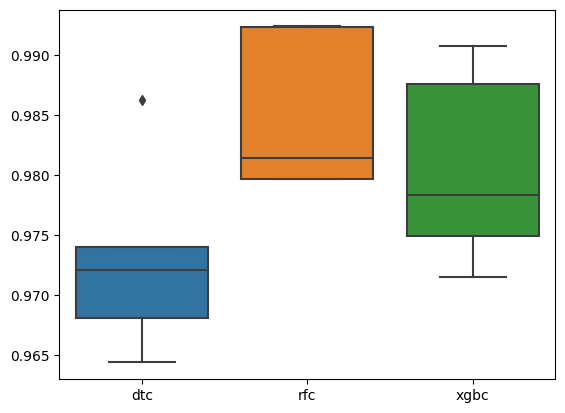

In [17]:
sns.boxplot(data=pd.DataFrame({'dtc': dtc_score,
                               'rfc': rfc_score,
                               'xgbc': xgbc_score}))

In [18]:
abc_score.max()

0.40693503458286834

The Random Forest Classifier is performing better than the other baseline considerations on average.

# Hyper-parameterization

## Decision Tree

In [86]:
grid_param = {
    'class_weight': [None, 'balanced'],
    'max_depth': [None, 20, 50, 100]
}

dtc_grid = GridSearchCV(dtc, grid_param, cv=5,
                        verbose=1, n_jobs=-1)

In [87]:
dtc_grid.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=0), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [None, 20, 50, 100]},
             verbose=1)

In [88]:
dtc_grid.best_score_, dtc_grid.best_params_

(0.9731404766337739, {'class_weight': None, 'max_depth': None})

## Random Forest

In [89]:
param_dict = {
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [2, 5],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

rfc_random = RandomizedSearchCV(rfc, param_dict, n_iter=100, cv=5,
                                verbose=1, random_state=0, n_jobs=-1)

In [90]:
rfc_random.fit(X, y.values.ravel())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=0, verbose=1)

In [91]:
rfc_random.best_score_, rfc_random.best_params_

(0.9862651275367715,
 {'n_estimators': 1000,
  'min_samples_split': 5,
  'min_samples_leaf': 1,
  'max_depth': None})

In [99]:
grid_param = {
    'n_estimators': [200, 1200, 1500],
    'min_samples_split': [2,3, 4],
    'max_features': [None]
}

rfc_grid = GridSearchCV(rfc, grid_param, cv=5,
                        verbose=1, n_jobs=-1, scoring='f1_weighted')

In [100]:
rfc_grid.fit(X, y.values.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0), n_jobs=-1,
             param_grid={'max_features': [None], 'min_samples_split': [2, 3, 4],
                         'n_estimators': [200, 1200, 1500]},
             scoring='f1_weighted', verbose=1)

In [101]:
rfc_grid.best_score_, rfc_grid.best_params_

(0.9882424229990907,
 {'max_features': None, 'min_samples_split': 3, 'n_estimators': 1200})

In [102]:
n_estimators = [100, 200, 1000, 1200]
row = []

for rand in range(25):
    for n_est in n_estimators:
        rfc_test = RandomForestClassifier(n_estimators=n_est,
                                          max_features=None,
                                          min_samples_leaf=3,
                                          random_state=rand)
        score = cross_val_score(rfc_test, X, y.values.ravel(), cv=5,
                                scoring='f1_weighted')
        
        row.append([n_est, score.mean()])
            

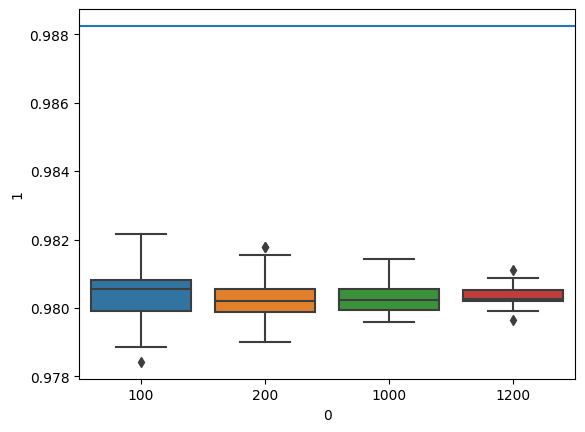

In [103]:
sns.boxplot(pd.DataFrame(row), x=0, y=1)
plt.axhline(y=rfc_grid.best_score_)

In [57]:
rfc_best = RandomForestClassifier(n_estimators=240, random_state=0, max_features=None)
rfc_best.fit(X, y)

/tmp/ipykernel_1071/4192466293.py:2: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(max_features=None, n_estimators=240, random_state=0)

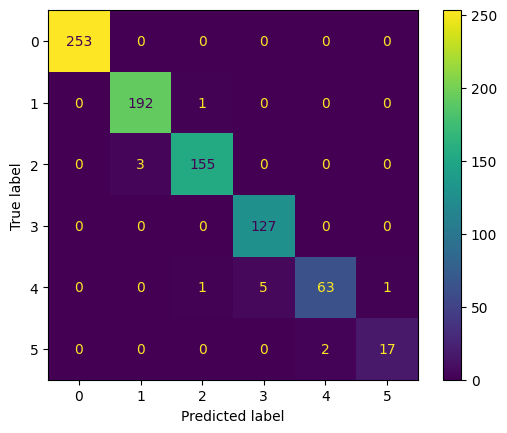

In [58]:
ConfusionMatrixDisplay.from_estimator(rfc_best, X_test, y_test)

In [69]:
df_rfc = pd.merge(X_test, y_test, how='left', left_index=True, right_index=True)
df_rfc['Pred'] = rfc_best.predict(X_test)
df_rfc.loc[df_rfc['Pred'] != df_rfc['Rank']]

,Level,Health,Energy,Sanity,Rank,Pred
156,2,28.78,29.72,25.24,5,4
825,19,154.75,153.46,153.61,3,4
1963,1,5.32,4.78,8.39,2,1
317,20,198.38,198.27,200.60,4,5
1876,1,11.40,10.28,8.48,3,4
1116,3,15.25,15.18,15.01,2,1
944,1,4.69,5.78,4.78,2,1


## XGBoost

In [56]:
param_dict = {
    'n_estimators': [50, 75, 100, 125, 150],
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [2, 3, 4]
}

xgbc_grid = GridSearchCV(xgbc, param_dict, cv=5,
                         verbose=1, n_jobs=-1)

In [57]:
xgbc_grid.fit(X, y)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [50, 75, 100, 125, 150]},
             verbose=1)

In [58]:
xgbc_grid.best_score_

0.9535876780786156

In [59]:
xgbc_grid.best_params_

{'learning_rate': 0.3, 'max_depth': 4, 'n_estimators': 100}

In [60]:
param_dict = {
    'n_estimators': [100],
    'learning_rate': [0.3, 0.4, 0.5, 0.6],
    'max_depth': [4, 5, 6, 7]
}

xgbc_grid = GridSearchCV(xgbc, param_dict, cv=5,
                         verbose=1, n_jobs=-1)

In [61]:
xgbc_grid.fit(X, y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.3, 0.4, 0.5, 0.6],
                         'max_depth': [4, 5, 6, 7], 'n_estimators': [100]},
             verbose=1)

In [62]:
xgbc_grid.best_score_, xgbc_grid.best_params_

(0.9560322965614978,
 {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 100})

In [63]:
param_dict = {
    'n_estimators': [100],
    'learning_rate': [0.5],
    'max_depth': [7, 10, 20]
}

xgbc_grid = GridSearchCV(xgbc, param_dict, cv=5,
                         verbose=1, n_jobs=-1)

In [64]:
xgbc_grid.fit(X, y)
xgbc_grid.best_score_, xgbc_grid.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


(0.9560322965614978,
 {'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 100})

In [65]:
xgbc_best = xgbc_grid.best_estimator_

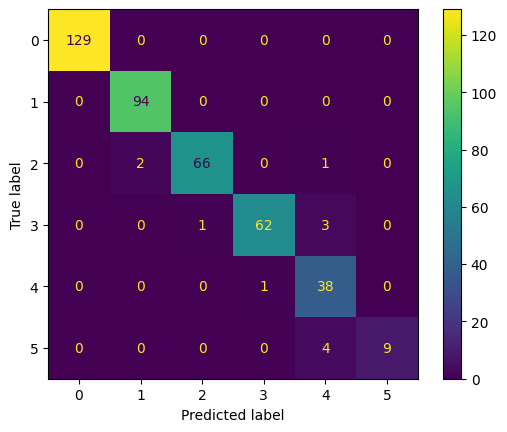

In [66]:
ConfusionMatrixDisplay.from_estimator(xgbc_best, X_test, y_test)

In [88]:
rfc_best.predict(X.sample(1))

array([1])

# Support Vector Machine

In [32]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

svc = make_pipeline(StandardScaler(),
                    LinearSVC(multi_class='crammer_singer',
                              random_state=0,
                              max_iter=10_000_000,
                              penalty='l1'))

In [33]:
svc.fit(X, y.values.ravel())

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearsvc',
                 LinearSVC(max_iter=10000000, multi_class='crammer_singer',
                           penalty='l1', random_state=0))])

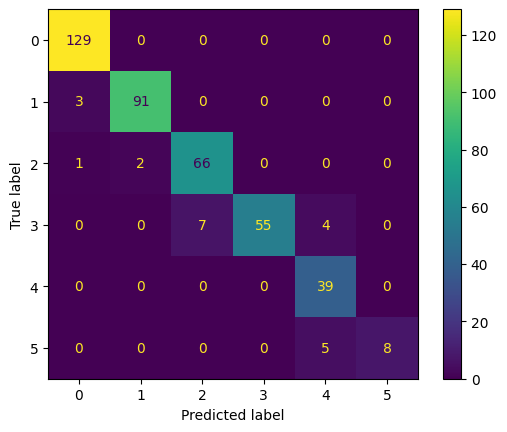

In [34]:
ConfusionMatrixDisplay.from_estimator(svc, X_test, y_test)

In [35]:
cross_val_score(svc, X, y.values.ravel(), cv=5, scoring='f1_weighted')

/home/levi/.local/share/virtualenvs/BandersnatchStarter-H27bAAec/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/levi/.local/share/virtualenvs/BandersnatchStarter-H27bAAec/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


array([0.94395398, 0.9119935 , 0.90970625, 0.91968731, 0.91660823])

# KNN

In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [52]:
knc = KNeighborsClassifier(weights='distance', algorithm='auto',
                           n_jobs=-1, leaf_size=2)
knc_score = cross_val_score(knc, X, y.values.ravel(), cv=5,
                            verbose=1, n_jobs=-1)
sorted(knc_score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished


[0.8348623853211009,
 0.8445121951219512,
 0.8597560975609756,
 0.8780487804878049,
 0.8807339449541285]

In [54]:
knc.fit(X, y.values.ravel())

KNeighborsClassifier(leaf_size=2, n_jobs=-1, weights='distance')

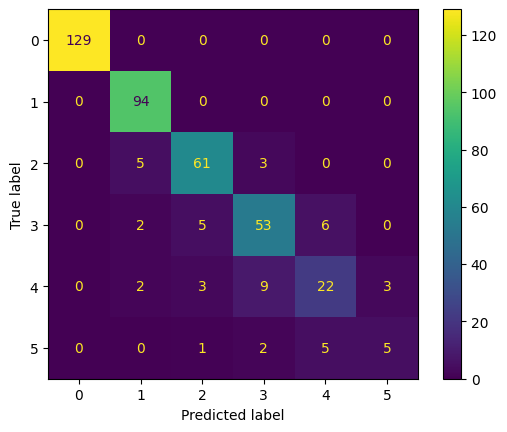

In [55]:
ConfusionMatrixDisplay.from_estimator(knc, X_test, y_test)